In [1]:
#importing openCV
import cv2

#importing numpy
import numpy as np

#importing pandas to read the CSV file containing our data
import pandas as pd

In [2]:
# #importing keras and sub-libraries
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras.layers import Flatten, MaxPool2D
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras import backend as K
# from keras.utils import np_utils
# from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

C:\Users\ANKIT SINGH\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ANKIT SINGH\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ANKIT SINGH\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ANKIT SINGH\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [3]:
def extract_plate(img): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    plate = None  # Initialize plate to None
    
    #Loads the data required for detecting the license plates from cascade classifier.
    plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')

    # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7)

    for (x,y,w,h) in plate_rect:
        a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning
        plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
        # finally representing the detected contours by drawing rectangles around the edges.
        cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
        
    return plate_img, plate # returning the processed image.


In [4]:
plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')

In [5]:
#detect the plate and return car + plate image
def plate_detect(img):
    plateImg = img.copy()
    roi = img.copy()
    plateRect = plate_cascade.detectMultiScale(plateImg,scaleFactor = 1.7, minNeighbors = 7)
    for (x,y,w,h) in plateRect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_part = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plateImg,(x+2,y),(x+w-3, y+h-5),(0,255,0),3)
    return plateImg, plate_part

In [6]:
#normal function to display 
def display_img(img):
    img_ = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img_)
    plt.show()

In [7]:
# #test image is used for detecting plate
# inputImg = cv2.imread("car_img.jpeg")
# processed_img = plate_detect(inputImg)
# display_img(processed_img[0])

In [8]:
# display_img(processed_img[1])

In [15]:
# # Read the image using OpenCV
# img = cv2.imread("car2.jpeg")

# # Call the function
# processed_img = extract_plate(img)

# processed_img = [np.array(img, dtype=np.float32) for img in processed_img]

# Initialize the camera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
else:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if ret:
        # Apply the extract_plate function
        processed_img = extract_plate(frame)

        # Display the resulting frame
        cv2.imshow('Processed Image', processed_img[0])
        
        if processed_img is not None:
            cv2.imshow('Detected Plate', processed_img[1])
        
        # Wait for a key press and close the window
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Error: Could not read frame from camera.")

# When everything is done, release the capture
cap.release()

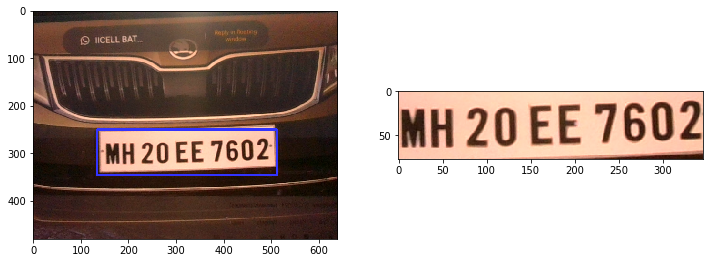

In [16]:
# Display the result 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(processed_img[0])
plt.subplot(1,2,2)
plt.imshow(processed_img[1])
plt.show()

In [17]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [18]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

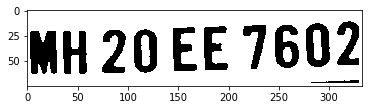

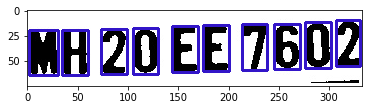

In [19]:
char = segment_characters(processed_img[1])

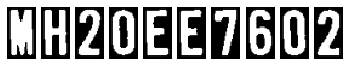

In [20]:
for i in range(len(char)):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for Characters

In [16]:
import tensorflow as tf
# tf.enable_eager_execution()

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'data_copy/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
#         batch_size=1,
        color_mode='grayscale',
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data_copy/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        color_mode='grayscale',
        class_mode='categorical')


# from keras.preprocessing.image import ImageDataGenerator

# # Initialize the data generator
# train_datagen = ImageDataGenerator(rescale=1./255)
# validation_datagen = ImageDataGenerator(rescale=1./255)

# # Create data generators
# train_generator = train_datagen.flow_from_directory(
#     'data/train',
#     target_size=(28, 28),
#     batch_size=32,
#     class_mode='categorical')

# validation_generator = validation_datagen.flow_from_directory(
#     'data/val',
#     target_size=(28, 28),
#     batch_size=32,
#     class_mode='categorical')


Found 5479 images belonging to 36 classes.
Found 789 images belonging to 36 classes.


In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D, BatchNormalization
from tensorflow.keras import optimizers

In [91]:
# model = Sequential()
# model.add(Conv2D(32, (24,24), input_shape=(28, 28, 1), activation='relu', padding='same'))
# # model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# # model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(36, activation='softmax'))

# # Define the model
model = Sequential()

# # Add layers
# model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu', padding='same'))
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(36, activation='softmax'))

# Add layers
model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(36, activation='softmax'))

# Display the model summary
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         73856     
__________

In [80]:
# class stop_training_callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_acc') > 0.992):
#       self.model.stop_training = True

# Define the callback class
# class stop_training_callback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         if logs is None:
#             logs = {}
#         # Update 'val_accuracy' if using a newer version of TensorFlow/Keras
#         val_acc = logs.get('val_accuracy')
#         if val_acc is not None and val_acc > 0.992:
#             self.model.stop_training = True

In [81]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [82]:
# import shutil
# import datetime
# import os
# # !rm -rf logs
# if os.path.exists("logs"):
#     shutil.rmtree("logs")
# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [149]:
batch_size = 32
# callbacks = [stop_training_callback(), tensorboard_callback]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // 1,
      epochs = 200)

# model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
#     epochs=80,
#     callbacks=callbacks)

Epoch 1/200
172/172 [==============================] - 17s 99ms/step - loss: 0.2969 - acc: 0.9159 - val_loss: 0.4045 - val_acc: 0.8707
Epoch 2/200
172/172 [==============================] - 17s 97ms/step - loss: 0.2959 - acc: 0.9126 - val_loss: 0.4042 - val_acc: 0.8771
Epoch 3/200
172/172 [==============================] - 17s 98ms/step - loss: 0.2983 - acc: 0.9151 - val_loss: 0.3833 - val_acc: 0.8733
Epoch 4/200
172/172 [==============================] - 17s 99ms/step - loss: 0.2972 - acc: 0.9106 - val_loss: 0.3953 - val_acc: 0.8606
Epoch 5/200
172/172 [==============================] - 24s 138ms/step - loss: 0.2892 - acc: 0.9160 - val_loss: 0.4075 - val_acc: 0.8657
Epoch 6/200
172/172 [==============================] - 17s 98ms/step - loss: 0.2864 - acc: 0.9149 - val_loss: 0.4256 - val_acc: 0.8657
Epoch 7/200
172/172 [==============================] - 16s 96ms/step - loss: 0.2927 - acc: 0.9140 - val_loss: 0.4071 - val_acc: 0.8733
Epoch 8/200
172/172 [==============================] -

172/172 [==============================] - 17s 97ms/step - loss: 0.2451 - acc: 0.9283 - val_loss: 0.3887 - val_acc: 0.8821
Epoch 76/200
172/172 [==============================] - 17s 97ms/step - loss: 0.2449 - acc: 0.9235 - val_loss: 0.3701 - val_acc: 0.8821
Epoch 77/200
172/172 [==============================] - 17s 97ms/step - loss: 0.2533 - acc: 0.9252 - val_loss: 0.3847 - val_acc: 0.8872
Epoch 78/200
172/172 [==============================] - 17s 98ms/step - loss: 0.2414 - acc: 0.9292 - val_loss: 0.3957 - val_acc: 0.8771
Epoch 79/200
172/172 [==============================] - 17s 99ms/step - loss: 0.2428 - acc: 0.9277 - val_loss: 0.3900 - val_acc: 0.8859
Epoch 80/200
172/172 [==============================] - 17s 99ms/step - loss: 0.2488 - acc: 0.9272 - val_loss: 0.3700 - val_acc: 0.8771
Epoch 81/200
172/172 [==============================] - 17s 98ms/step - loss: 0.2347 - acc: 0.9286 - val_loss: 0.3681 - val_acc: 0.8885
Epoch 82/200
172/172 [==============================] - 17s 9

Epoch 149/200
172/172 [==============================] - 17s 98ms/step - loss: 0.1995 - acc: 0.9385 - val_loss: 0.3757 - val_acc: 0.8834
Epoch 150/200
172/172 [==============================] - 17s 99ms/step - loss: 0.2073 - acc: 0.9352 - val_loss: 0.3767 - val_acc: 0.8885
Epoch 151/200
172/172 [==============================] - 17s 98ms/step - loss: 0.2205 - acc: 0.9330 - val_loss: 0.3749 - val_acc: 0.8885
Epoch 152/200
172/172 [==============================] - 16s 95ms/step - loss: 0.2165 - acc: 0.9350 - val_loss: 0.3572 - val_acc: 0.8796
Epoch 153/200
172/172 [==============================] - 18s 103ms/step - loss: 0.2263 - acc: 0.9330 - val_loss: 0.3383 - val_acc: 0.8999
Epoch 154/200
172/172 [==============================] - 24s 139ms/step - loss: 0.2033 - acc: 0.9378 - val_loss: 0.3623 - val_acc: 0.8935
Epoch 155/200
172/172 [==============================] - 16s 94ms/step - loss: 0.2020 - acc: 0.9367 - val_loss: 0.3685 - val_acc: 0.8809
Epoch 156/200
172/172 [================

In [150]:
# # !kill 8400
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [35]:
# save the model
model.save('model2.h5')

NameError: name 'model' is not defined

In [22]:
from tensorflow.keras.models import load_model

# To load the model later
loaded_model = load_model('model2.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [23]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         73856     
__________

In [24]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,1))
  for i in range(1):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,1) #preparing image for the model
        y = loaded_model.predict(img)[0] #predicting the class
        y = y.argmax()
        character = dic[y] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

7H20EE7602


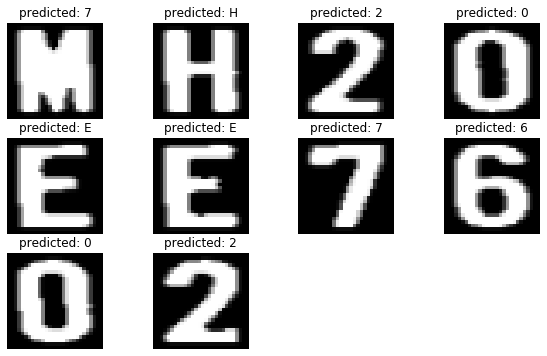

In [25]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()